In [1]:
import pandas as pd
import folium
from folium.plugins import FastMarkerCluster
import branca

#constants
year_start=1929
year_end=2025
mile_range=10
thunder_over_avg=10
thunder_over_avg_ratio=1.5
file_start_dates=[1929,1970,1980,1990,2000,2010,2020]
file_end_dates=[1969,1979,1989,1999,2009,2019,2025]
color_list=['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen',
             'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
#loading Meteorite data and cleaning it
Meteorites_Landings=pd.read_csv(f'Meteorite_Landings.csv')
Meteorites_Landings.dropna(subset=['year','GeoLocation','reclat','reclong'],inplace=True,ignore_index=True)
# remove all meteorites with a 0,0 latitude,longitude and an outlier that is a meteorite on Mars
Meteorites_Landings=Meteorites_Landings[(Meteorites_Landings['GeoLocation']!="(0.0, 0.0)") &
                                        (Meteorites_Landings['reclong']<180.0)].reset_index(drop=True)

#creating map
map_fig=folium.Figure(width=800,height=500)
world_map=folium.Map(location=[10.0,15.0],tiles=folium.TileLayer(no_wrap=True),zoom_start=1.5,control_scale=True).add_to(map_fig)

#javascript functions for creating markers in the FastMarkerCluster calls below
callback_meteor = """\
function (row) {
    var marker;
    marker = L.circleMarker(new L.LatLng(row[0], row[1]),{color:'red',radius:3});
    marker.bindPopup(row[2]);
    return marker;
};
"""
callback_station = """\
function (row) {
    var marker;
    marker = L.circleMarker(new L.LatLng(row[0], row[1]),{color:'blue',radius:3});
    marker.bindPopup(row[2]);
    return marker;
};
"""

#FastMarkerCluster of all Meteorite locations - replace with MarkerCluster for popup functionality
All_Meteorites=folium.FeatureGroup(name='All Meteorites',show=False).add_to(world_map)
All_Meteorites.add_child(FastMarkerCluster(Meteorites_Landings[['reclat', 'reclong', 'name']].values.tolist(),
                                      callback=callback_meteor))

#Adding all stations to the map is too resource intensive
#------------------------------------------------------------------------------------------------------
# #loading dataframe for unique stations
# Unique_Stations_df=pd.read_csv(f'All_Stations_{year_start}_{year_end}.csv')
# Station_Group=folium.FeatureGroup(name='All Stations',show=False).add_to(world_map)
# station_info=['LATITUDE','LONGITUDE','NAME']
# for year in range(year_start,year_end):
#     #Station_Subgroup = folium.FeatureGroup(name=f'Stations in {year}',show=False).add_to(Station_Group)
#     column_year=f'{year}'
#     Stations_in_Year=Unique_Stations_df[Unique_Stations_df[column_year]==True][station_info]
#     Station_Group.add_child(FastMarkerCluster(Stations_in_Year.values.tolist(),
#                                           callback=callback_station,name=f'Stations in {year}',show=False))
#---------------------------------------------------------------------------------------------------------
#
#create lists for future plots
meteorite_name=[]
average_thunderstorms=[]
thunderstorms_above_avg=[]
thunderstorms_in_year=[]
thunderstorms_ratio=[]
#loop through all analyzed data sets of meteorites and create layers of markers for each dataset
total_loops=len(file_start_dates)
for i in range(0,total_loops):
    year_start=file_start_dates[i]
    year_end=file_end_dates[i]
    #if loop is larger than the list of colors, cycle back through the color list
    j=i%(len(color_list))
    icon_color=color_list[j]
    #loading Station Data
    Meteorite_analysis=pd.read_csv(f'Meteorite_Analysis_{year_start}to{year_end}_{mile_range}miles_{thunder_over_avg}a{thunder_over_avg_ratio}thunder.csv')
    
    #creating groups for each map layer
    Thunder_Meteorites=folium.FeatureGroup(name=f'{year_start}-{year_end} Candidates in {icon_color}',show=True).add_to(world_map)

    #creating small popup map for each candidate meteor with the associated stations in range and a bounding box on the 10 mile range
    #initialize arguments for icons and rectangle
    marker_icon = {"prefix": "fa", "color": icon_color, "icon": "meteor"}
    mark_icon = folium.Icon(**marker_icon)
    station_icon= {"prefix": "fa", "color": color_list[8], "icon": "hurricane"}
    rectangle_kw = {"color": "red","weight": 5,"line_cap": "round"}
    #loop through each meteorite candidate
    for index, row in Meteorite_analysis.iterrows():
        #create a figure and map for each meteorite to be placed in a popup
        meteorite_Fig=branca.element.Figure()
        meteorite_Map=folium.Map([row['reclat'],row['reclong']],zoom_start=9,control_scale=True).add_to(meteorite_Fig)
        #create a marker for the meteorite and a bounding rectangle around that marker for the popup map
        folium.Marker(location=(row['reclat'],row['reclong']),icon=folium.Icon(**marker_icon),popup=folium.Popup(row['name'],show=True)).add_to(meteorite_Map)
        folium.Rectangle(bounds=[[row['max_lat'],row['max_long']],[row['min_lat'],row['min_long']]],**rectangle_kw).add_to(meteorite_Map)
        #pull out the stations associated with each meteorite and create markers for them inside the popup map
        stations=eval(row['Stations_in_Range'])
        for station in stations:
            folium.Marker(location=(station['LATITUDE'],station['LONGITUDE']),icon=folium.Icon(**station_icon),popup=station['NAME'],show=True).add_to(meteorite_Map)
        #create an IFrame, add the figure to the IFrame, and create a popup that calls the IFrame
        meteorite_IFrame=branca.element.IFrame(width=250,height=200)
        meteorite_Fig.add_to(meteorite_IFrame)
        meteorite_popup=folium.Popup(meteorite_IFrame,max_width=500)
        #create the marker with the popup map
        folium.Marker(location=(row['reclat'],row['reclong']),icon=mark_icon,popup=meteorite_popup).add_to(Thunder_Meteorites)

        #add the meteorite name and thunderstorm data to the lists for future plots
        meteorite_name.append(row['name'])
        average_thunderstorms.append(row['Area_Thunder_Average'])
        thunderstorms_above_avg.append(row['Thunder_Instances']-row['Area_Thunder_Average'])
        thunderstorms_in_year.append(row['Thunder_Instances'])
        thunderstorms_ratio.append(row['Landing_Thunder_above_Average'])

#show the layer control, save and display the map
folium.LayerControl(collapsed=False,position='bottomright').add_to(world_map)
world_map.save('Meteorite_Map.html')
world_map

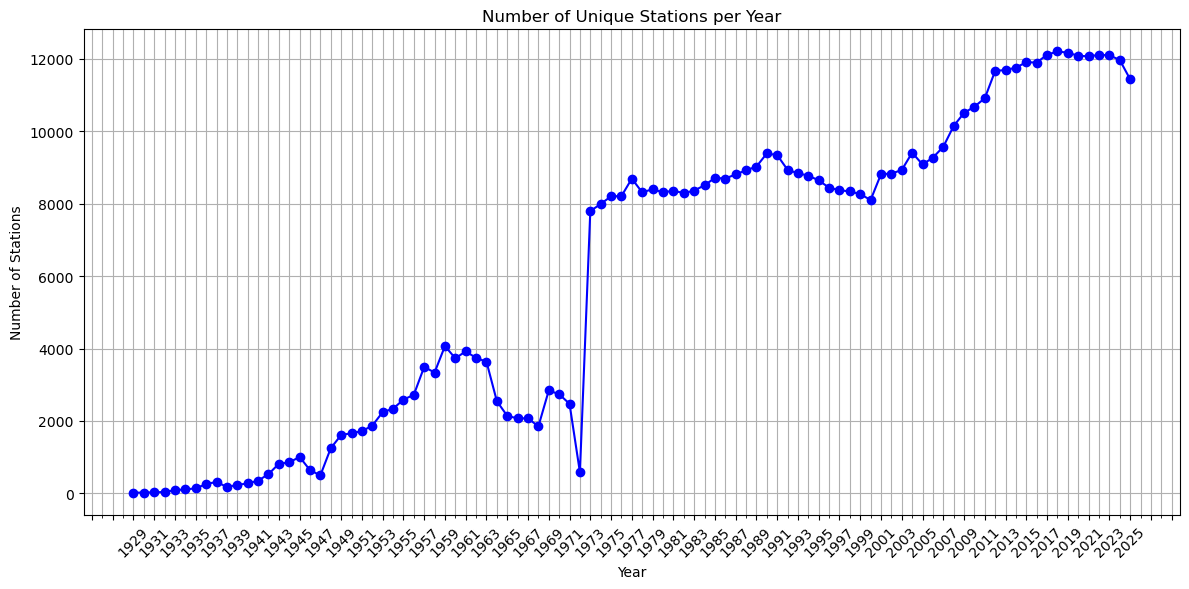

In [2]:
#load unique stations csv file
year_start=1929
year_end=2025
Unique_Stations_df=pd.read_csv(f'All_Stations_{year_start}_{year_end}.csv')
#make plot of number of stations per year
import matplotlib.pyplot as plt
# Count the number of stations for each year
stations_per_year = Unique_Stations_df.sum(axis=0).drop(['LATITUDE', 'LONGITUDE', 'NAME']).values
years = Unique_Stations_df.columns[3:]  # Skip the first three columns (LATITUDE, LONGITUDE, NAME)


# Create a line plot
plt.figure(figsize=(12, 6))
plot=plt.plot(years, stations_per_year, marker='o', linestyle='-', color='blue')
plt.title('Number of Unique Stations per Year')
plt.xlabel('Year')
plt.ylabel('Number of Stations')
import matplotlib.ticker as mticker
myLocator = mticker.MultipleLocator(2)

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(myLocator)
plt.gca().xaxis.set_minor_locator(mticker.MultipleLocator(1))
plt.grid(visible=True,which='both')
plt.tight_layout()
plt.savefig('Unique_Stations_per_Year.png')
plt.show()

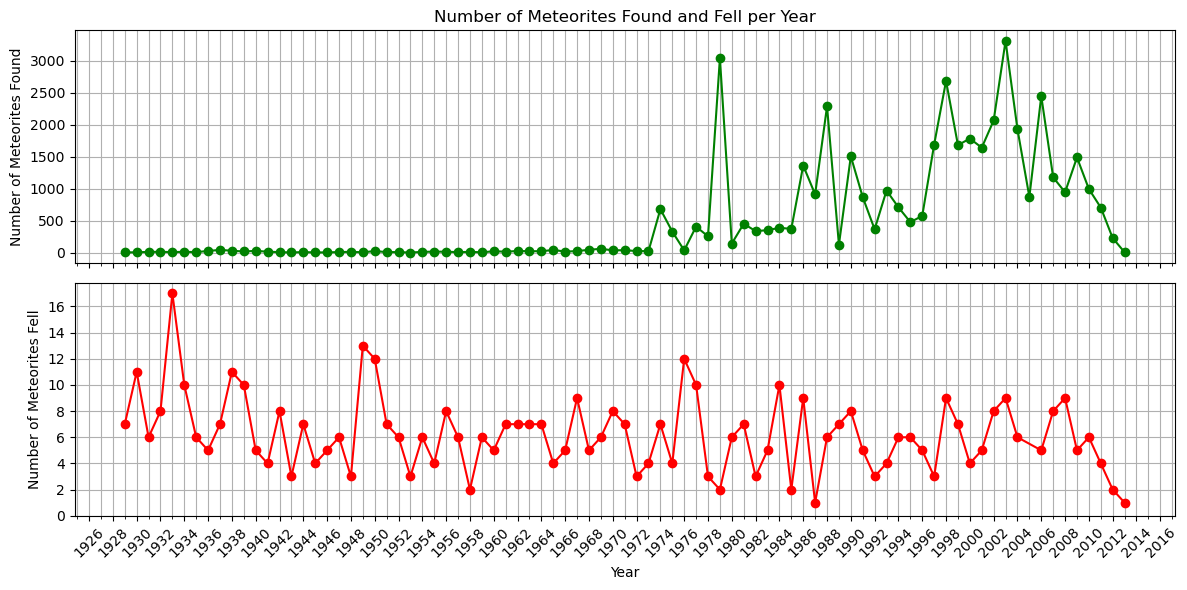

In [3]:
#load meteorite data
Meteorites_Landings=pd.read_csv(f'Meteorite_Landings.csv')
#make line plot of number of meteorites found and fell per year in range of year_start to year_end
Meteorites_per_year = Meteorites_Landings[(Meteorites_Landings['year'] >= year_start) & (Meteorites_Landings['year'] <= year_end)]
Found_Meteorites = Meteorites_per_year[Meteorites_per_year['fall'] == 'Found']
Fell_Meteorites = Meteorites_per_year[Meteorites_per_year['fall'] == 'Fell']
Found_Meteorites_count = Found_Meteorites['year'].value_counts().sort_index()
Fell_Meteorites_count = Fell_Meteorites['year'].value_counts().sort_index()


# Create vertically stacked line subplots for meteorites found and fell per year
import matplotlib.ticker as mticker
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax1.plot(Found_Meteorites_count.index, Found_Meteorites_count.values, marker='o', linestyle='-', color='green', label='Found Meteorites')
ax1.set_ylabel('Number of Meteorites Found')
ax1.set_title('Number of Meteorites Found and Fell per Year')
ax1.grid(visible=True, which='both')

       
ax2.plot(Fell_Meteorites_count.index, Fell_Meteorites_count.values, marker='o', linestyle='-', color='red', label='Fell Meteorites')
ax2.set_ylabel('Number of Meteorites Fell')
ax2.set_xlabel('Year')

ax2.grid(visible=True, which='both')        

plt.gca().xaxis.set_minor_locator(mticker.MultipleLocator(1))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
plt.xticks(rotation=45)
plt.sca(ax2)
plt.yticks(range(0, Fell_Meteorites_count.max() + 1, 2))
plt.tight_layout()
plt.savefig('Meteorites_Found_and_Fell_per_Year.png')
plt.show()


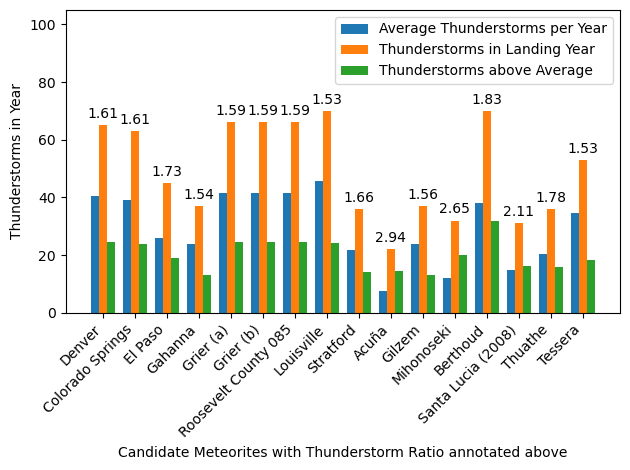

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data
# meteorite_name
# average_thunderstorms
# thunderstorms_above_avg
# thunderstorms_in_year
# thunderstorm_ratio
categories = meteorite_name
group1 = average_thunderstorms
group2 = thunderstorms_in_year
group3 = thunderstorms_above_avg

# Bar width and positions
x = np.arange(len(categories))  # the label locations
width = 0.25  # width of the bars

# Plotting
fig, ax = plt.subplots()
bars1 = ax.bar(x - width, group1, width, label='Average Thunderstorms per Year')
bars2 = ax.bar(x, group2, width, label='Thunderstorms in Landing Year')
bars3 = ax.bar(x + width, group3, width, label='Thunderstorms above Average')

# Adding labels, title, and legend
ax.set_xlabel("Candidate Meteorites with Thunderstorm Ratio annotated above")
ax.set_ylabel('Thunderstorms in Year')
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right', va='top')
ax.legend()
ax = plt.gca()
ax.set_ylim([0, 105])

# Annotating bars with values

for i in range(0,len(bars2)):
    height = bars2[i].get_height()
    ax.annotate(f'{thunderstorms_ratio[i]:.2f}',
                xy=(bars2[i].get_x() + bars2[i].get_width() / 2, height),
                xytext=(0, 3),  # Offset text by 3 points
                textcoords="offset points",
                ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.savefig('Candidate Meteorite Bar Chart.png')
plt.show()
